## Задание 1

Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).

Функция должна быть написана на python. В ходе решения можно тестировать работу функции как на полном датасете, так и на части (сэмпле) данных.

Мое понимание задачи: нужно написать функцию, которая будет принмать на вход:
 - путь к файлу с данными о времени регистрации;
 - путь к файлу с данными о времени захода пользователей в игру;
 - дату регистрации пользователя;
 - день возврата относительно даты регистрации.
 
Фразу "по дням от даты регистрации" я понимаю как расчет по календарномы дню, а не по 24 часовому периоду.

Необходимо также описать случаи:
- если нет пользователей, зарегистрировавшихся в указанную дату;
- если дата регистрации находится вне диапазона данных;
- если дата дня N находится вне диапазона данных;

 
Таким образом считаем : N-day retention rate, который показывает какой процент пользователей вернулся к нам на N ный день после регистрации


Импортируем библиотеки

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline


Запишем пути к файлам

In [6]:
reg_file = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-posazhennikov/shared/problem1-reg_data.csv'
auth_file = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-posazhennikov/shared/problem1-auth_data.csv'

Перед тем как написать функцию, посмотрим и проанализируем датафреймы, посмотрим размер, типы данных, количество уникальных uid, нулевых строк, дубликатов 

In [7]:
reg = pd.read_csv(reg_file, sep = ';')


In [8]:
reg.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [9]:
reg.describe()

,reg_ts,uid
count,1.000000e+06,1.000000e+06
mean,1.548332e+09,5.552354e+05
std,5.253653e+07,3.206011e+05
min,9.113822e+08,1.000000e+00
25%,1.528034e+09,2.776438e+05
50%,1.564454e+09,5.550455e+05
75%,1.585759e+09,8.329712e+05
max,1.600874e+09,1.110622e+06


In [10]:
reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB


In [11]:
reg.nunique()

reg_ts    1000000
uid       1000000
dtype: int64

In [12]:
reg.loc[reg.duplicated()]

,reg_ts,uid


In [13]:
auth = pd.read_csv(auth_file, sep = ';')


In [14]:
auth.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [15]:
auth.describe()

,auth_ts,uid
count,9.601013e+06,9.601013e+06
mean,1.548778e+09,3.347198e+05
std,5.160527e+07,2.832669e+05
min,9.113822e+08,1.000000e+00
25%,1.528375e+09,9.599700e+04
50%,1.564577e+09,2.579210e+05
75%,1.585823e+09,5.190250e+05
max,1.600874e+09,1.110622e+06


In [16]:
auth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
dtypes: int64(2)
memory usage: 146.5 MB


In [17]:
auth.nunique()

auth_ts    9180915
uid        1000000
dtype: int64

In [18]:
auth.loc[auth.duplicated()]

,auth_ts,uid


## Вывод:

Датафреймы не имеют нулевых строк и дубликатов, имеют общую колонку uid в которой находится 1,000,000 уникальных имен пользователей, что позволит нам объединить по ней датафреймы 

## Далее, для удобства тестирования я разбил задачу на три этапа:
1. Получение датафрейма
2. Функция преобразовывающая датафресм в сводную таблицу и показывающая heatmap размером равным день возврата+1 
3. Функция, считающая Retention rate по дате регистрации и дню N

### 1. Напишем функцию get_data принимает на вход путь к файлам и возвращает итоговый датафрейм,а также информацию о нем. И заодно считает сколько дней прошло с момента регистрации до входа

In [370]:
def get_data(path_reg, path_auth):
    
# Прочитаем файлы    
    reg = pd.read_csv(path_reg, sep = ';')
    auth = pd.read_csv(path_auth, sep = ';')
    
# Переведем колонки к виду "год-месяц-день"
# Поскольку задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока)
# будем считать retention по календарным дням

    reg['reg_ts'] = pd.to_datetime(reg.reg_ts, unit = 's' ).dt.date
    auth['auth_ts'] = pd.to_datetime(auth.auth_ts,unit= 's').dt.date

# Cоберем общий датафрейм

    reg_n_auth = auth.merge(reg, on= 'uid', how = 'left')
    
# Добавим колонку days_since_reg, куда запишем, сколько дней прошло с момента регистрации до входа

    reg_n_auth['days_since_reg'] = (reg_n_auth.auth_ts - reg_n_auth.reg_ts).apply(lambda x: x.days)
    
    print(f'{reg_n_auth.columns[0]} - колонка с датами авторизации')
    print('  минимальное значение:', reg_n_auth[reg_n_auth.columns[0]].min())
    print('  максимальное значение:', reg_n_auth[reg_n_auth.columns[0]].max())
    print()
    print(f'{reg_n_auth.columns[1]} - колонка с номерами пользователей')
    print()
    print(f'{reg_n_auth.columns[2]} - колонка с датами регистрации')    
    print('  минимальное значение:', reg_n_auth[reg_n_auth.columns[2]].min())
    print('  максимальное значение:', reg_n_auth[reg_n_auth.columns[2]].max())
#    print(f'{reg_n_auth.columns[3]} - колонка ')
    
    
    return reg_n_auth    
     

In [275]:
%%time
1 + 1
reg_n_auth =get_data(reg_file, auth_file)

auth_ts - колонка с датами авторизации
  минимальное значение: 1998-11-18
  максимальное значение: 2020-09-23

uid - колонка с номерами пользователей

reg_ts - колонка с датами регистрации
  минимальное значение: 1998-11-18
  максимальное значение: 2020-09-23
CPU times: user 2min 18s, sys: 4.83 s, total: 2min 23s
Wall time: 2min 39s


In [21]:
reg_n_auth.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9601013 entries, 0 to 9601012
Data columns (total 4 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   auth_ts         object
 1   uid             int64 
 2   reg_ts          object
 3   days_since_reg  int64 
dtypes: int64(2), object(2)
memory usage: 366.2+ MB


In [374]:
print(reg_n_auth.reg_ts.min())
print(reg_n_auth.reg_ts.max())
print(reg_n_auth.auth_ts.min())
print(reg_n_auth.auth_ts.max())

1998-11-18
2020-09-23
1998-11-18
2020-09-23


### 2. Напишем функцию, которая принимает на вход датафрейм, дату регистрации, день, на который надо посчитать retention и выдает сводную таблицу RR в виде heatmap

In [375]:
def get_retention(data_frame, regis_date, N_day):
# блок возвращает конечную дату из начальной + период, для создания heatmap
    reg_date = pd.to_datetime(regis_date)
    nN_day = pd.to_timedelta(N_day, unit = 'd')
    max_date = (reg_date + nN_day)
    
# В случае если дата регистрации или reg_date + N_day выходят за пределы датафрейма
    
    if reg_date > data_frame.reg_ts.max():
        return 'Нет данных о реигстрации пользователей в эту дату'
    elif max_date > data_frame.auth_ts.max():
        return f'Нет данных о возврате на {N_day} день после {regis_date}'
        

# Отфильтруем данные по периоду от даты регистрации до даты регистрации + N-day.
# сгруппируем по дате регистрации и количеству дней между регистрацией и входом и посчитаем количество uid
        
    cohort = data_frame.loc[(data_frame.reg_ts >= reg_date)\
                              & (data_frame.auth_ts <= max_date)\
                              & (data_frame.days_since_reg  <= N_day)]\
                         .groupby(['reg_ts','days_since_reg'], as_index= False).agg({'uid':'nunique'})


#     Приведем датафрейм к следующему виду:
#     - в индексах строк будут даты регистрации (наши когорты),
#     - в колонках - даты авторизации, 
#     - в ячейках датафрейма - количество uid пользователей




    prepared = cohort.pivot_table (index='reg_ts', columns='days_since_reg', values='uid')

# Разделим таблицу на первую колонку, в которй находится количество зарегистрированных пользователей на определенную дату
    
    retention = prepared.divide(prepared[0]/100, axis=0).round(2)

# Здесь блок, считающий параметр vmax для того, чтобы heatmap был красивый.
    vmax_ = retention.drop(columns = {0}).max().max()

    
    plt.figure(figsize = (20,15))    
    retention_heatmap = sns.heatmap(retention, vmax = vmax_,  annot=True, linewidth=.5,linecolor ='black', fmt=".2f")
    return retention_heatmap

In [391]:
reg_date ='2015-09-20'
N_day = 25

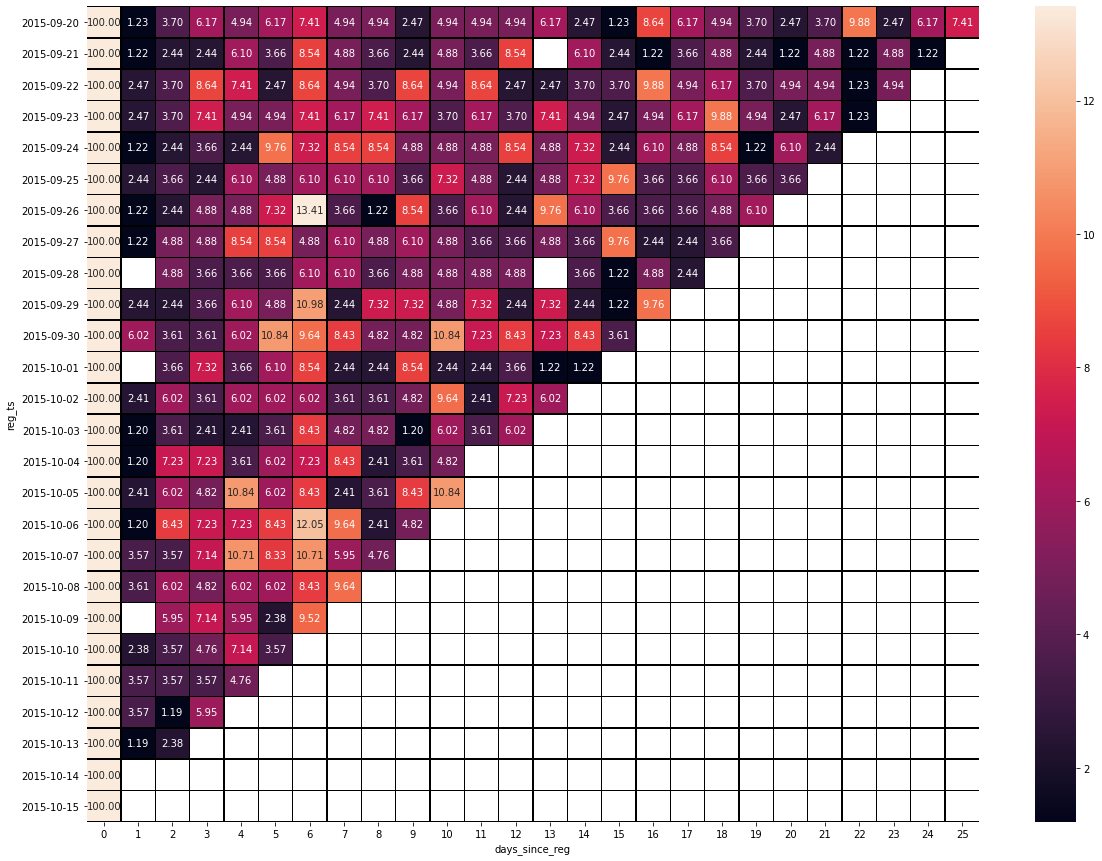

In [392]:
get_retention(reg_n_auth, reg_date, N_day)

### 3.Напишем функцию, которая принимает на вход датафрейм, дату регистрации пользователя, день, на который нужно посчитать retention и выдает Retention rate одной строкой.


In [382]:
def get_retention_upd(data_frame, regis_date, N_day):

# Отфильтруем данные по дате регистрации,
# сгруппируем по дате регистрации и посчитаем количество зарегистрированых пользователей в эту дату
    
    registered_on_date = data_frame.loc[(data_frame.reg_ts == pd.to_datetime(regis_date))]\
                            .groupby('reg_ts', as_index= False).agg({'uid':'nunique'})
    
# сгруппируем по дате регистрации и дню возврата и посчитаем, вколько пользователей вернулось в N-ный день

    returned = data_frame.loc[(data_frame.reg_ts == pd.to_datetime(regis_date)) & (data_frame.days_since_reg  == N_day)]\
                            .groupby(['reg_ts','days_since_reg'], as_index= False).agg({'uid':'nunique'})

# Разделим кол-во вернувшихся на кол-во зарегистрировавшихся.
# Учтем, что пользователи могли не регистрироваться в указанную дату

    
    
    if registered_on_date.shape[0] == 0: 
        print('Нет пользователей зарегистрировавшихся в эту дату')

    elif returned.shape[0] == 0:
        print(f'Retention rate для пользователей, зарегистрировавшихся {regis_date} на день {N_day} составит 0%')

    else:
        retention_result = (returned.uid.max() / registered_on_date.uid.max()*100).round(2)
        print(f'Retention rate для пользователей, зарегистрировавшихся {regis_date} на день {N_day} составит {retention_result}%')

    
    

In [383]:

get_retention_upd(reg_n_auth,reg_date,N_day)

Retention rate для пользователей, зарегистрировавшихся 2020-09-20 на день 2 составит 4.34%


## Итоговая функция, которая будет принмать путь к файлам, дату регистрации, день  возврата и считать RR по дате регистрации и N-дню  как число, а также выводить сводную как heatmap 

In [384]:
def get_retention_fin(path_reg,path_auth, regis_date, N_day):

#************************* ПОЛУЧЕНИЕ ОБЩЕГО ДАТАФРЕЙМА ********************************** 

# Прочитаем файлы    
    reg = pd.read_csv(path_reg, sep = ';')
    auth = pd.read_csv(path_auth, sep = ';')
    

#     Переведем колонки к виду "год-месяц-день"
#     Поскольку задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока),
#     будем считать retention по календарным дням


    reg['reg_ts'] = pd.to_datetime(reg.reg_ts, unit = 's').dt.date
    auth['auth_ts'] = pd.to_datetime(auth.auth_ts,unit= 's').dt.date

# Cоберем общий датафрейм

    data_frame = auth.merge(reg, on= 'uid', how = 'left')
    
# протестируем на части датафрейма (НЕ ЗАБУДЬ ПЕРЕИМЕНОВАТЬ ПРЕДЫДУЩИЙ ДЛЯ ИТОГА !!!)    
#    data_frame = reg_n_auth.tail(1000)
    
#************************* СОЗДАНИЕ НАГЛЯДНОГО HEATMAP **********************************   

# Добавим колонку days_since_reg, куда запишем, сколько дней прошло с момента регистрации до входа

    data_frame['days_since_reg'] = (data_frame.auth_ts - data_frame.reg_ts).apply(lambda x: x.days)
    
# блок возвращает конечную дату из начальной + период, для создания heatmap

    reg_date = pd.to_datetime(regis_date)
    nN_day = pd.to_timedelta(N_day, unit = 'd')
    max_date = (reg_date + nN_day)
    
# В случае если дата регистрации или reg_date + N_day выходят за пределы датафрейма
    
    if reg_date > data_frame.reg_ts.max():
        return 'Нет данных о реигстрации пользователей в эту дату'
    elif max_date > data_frame.auth_ts.max():
        return f'Нет данных о возврате на {N_day} день после {regis_date}'

# Отфильтруем данные по периоду от даты регистрации до даты регистрации + N-day.
# сгруппируем по дате регистрации и количеству дней между регистрацией и входом и посчитаем количество uid
        
    cohort = data_frame.loc[(data_frame.reg_ts >= reg_date)\
                              & (data_frame.auth_ts <= max_date)\
                              & (data_frame.days_since_reg  <= N_day)]\
                         .groupby(['reg_ts','days_since_reg'], as_index= False).agg({'uid':'nunique'})

#     Приведем датафрейм к следующему виду:
#     - в индексах строк будут даты регистрации (наши когорты),
#     - в колонках - даты авторизации, 
#     - в ячейках датафрейма - количество uid пользователей

    prepared = cohort.pivot_table (index='reg_ts', columns='days_since_reg', values='uid')

# Разделим таблицу на первую колонку, в которй находится количество зарегистрированных пользователей на определенную дату
    
    retention = prepared.divide(prepared[0]/100, axis=0).round(2)

# Здесь блок, считающий параметр vmax для того, чтобы heatmap был красивый.
    vmax_ = retention.drop(columns = {0}).max().max()

    
    plt.figure(figsize = (20,15))    
    retention_heatmap = sns.heatmap(retention, vmax = vmax_,  annot=True, linewidth=.5,linecolor ='black', fmt=".2f")

#************************* РАСЧЕТ RETENTION RATE ПО ДАТЕ РЕГИСТРАЦИИ И ДНЮ ********************************** 


# Отфильтруем данные по дате регистрации,
# сгруппируем по дате регистрации и посчитаем количество зарегистрированых пользователей в эту дату
    
    registered_on_date = data_frame.loc[(data_frame.reg_ts == pd.to_datetime(regis_date))]\
                            .groupby('reg_ts', as_index= False).agg({'uid':'nunique'})
    
# сгруппируем по дате регистрации и дню возврата и посчитаем, вколько пользователей вернулось в N-ный день

    returned = data_frame.loc[(data_frame.reg_ts == pd.to_datetime(regis_date)) & (data_frame.days_since_reg  == N_day)]\
                            .groupby(['reg_ts','days_since_reg'], as_index= False).agg({'uid':'nunique'})

#     Разделим кол-во вернувшихся на кол-во зарегистрировавшихся.
#     Учтем, что пользователи могли не регистрироваться в указанную дату

   
    if registered_on_date.shape[0] == 0: 
        print('Нет пользователей зарегистрировавшихся в эту дату')

    elif returned.shape[0] == 0:
        print(f'Retention rate для пользователей, зарегистрировавшихся {regis_date} на день {N_day} составит 0%')

    else:
        retention_result = (returned.uid.max() / registered_on_date.uid.max()*100).round(2)
        print(f'Retention rate для пользователей, зарегистрировавшихся {regis_date} на день {N_day} составит {retention_result}%')

    
    return retention_heatmap

    

In [393]:
# Вспомогательная ячейка, чтобы каждый раз не  возвращаться вверх
reg_date = reg_date
N_day = N_day

Retention rate для пользователей, зарегистрировавшихся 2015-09-20 на день 25 составит 7.41%
CPU times: user 2min 26s, sys: 1min 21s, total: 3min 47s
Wall time: 5min 21s


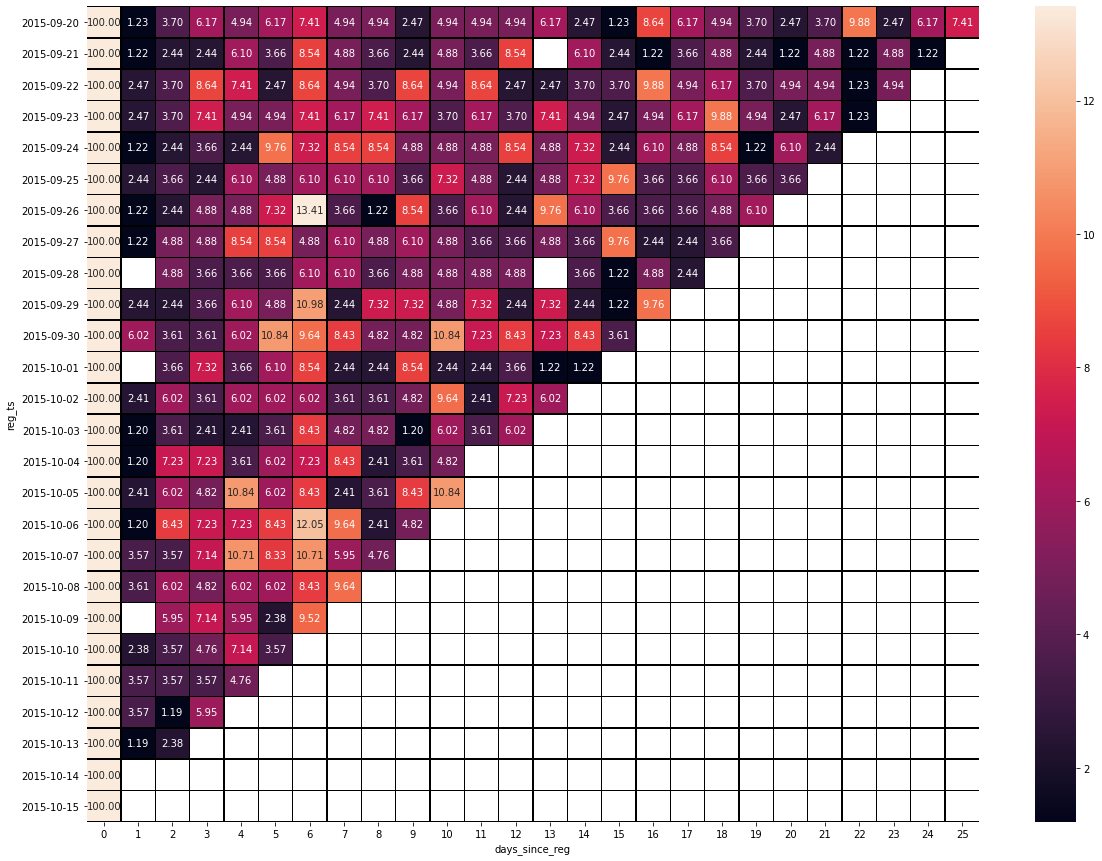

In [394]:
%%time
1 + 1
get_retention_fin(reg_file,auth_file, reg_date, N_day)